In [26]:
import sys
import os


# Get the project root (one level above notebooks/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

print("Added to Python path:", project_root)

import h5py
import numpy as np
import pandas as pd
# from src.parameters.tail_features import compute_LQ80
from scipy.fft import rfft, rfftfreq


Added to Python path: c:\Users\YooNi\OneDrive\Desktop\Majorana-Neutrino-Hunt


In [27]:
train_file = "../data/old/MJD_Train_0.hdf5"

with h5py.File(train_file, "r") as f:
    waveforms = np.array(f["raw_waveform"])
    ids = np.array(f["id"])

print("Loaded", len(waveforms), "waveforms")

Loaded 65000 waveforms


In [28]:
def compute_frequency_spectrum(waveform, sample_spacing=1.0):
    """
    Computes one-sided FFT amplitude spectrum of the waveform.

    Parameters
    ----------
    waveform : array-like
        The signal to transform.
    sample_spacing : float
        Time step between samples.

    Returns
    -------
    xf : np.ndarray
        Frequencies.
    amplitude : np.ndarray
        Real amplitude spectrum.
    """
    wf = np.asarray(waveform, dtype=float)
    wf = wf - np.mean(wf[:200])
    
    N = len(wf)

    yf = rfft(wf)
    xf = rfftfreq(N, d=sample_spacing)

    amplitude = np.abs(yf) * 2.0 / N
    return xf, amplitude


In [29]:
def compute_spectral_centroid(waveform, sample_spacing=1.0):
    freqs, amp = compute_frequency_spectrum(waveform, sample_spacing)

    total_amp = np.sum(amp)
    if total_amp == 0:
        return 0.0

    centroid = np.sum(freqs * amp) / total_amp
    return float(centroid)


In [30]:
SC_values = []
for i, wf in enumerate(waveforms):
    if i % 5000 == 0:
        print(f"Processing {i} / {len(waveforms)}")
    SC_values.append(compute_spectral_centroid(wf))

SC_values = np.array(SC_values, dtype=float)
SC_values[~np.isfinite(SC_values)] = np.nan

Processing 0 / 65000
Processing 5000 / 65000
Processing 10000 / 65000
Processing 15000 / 65000
Processing 20000 / 65000
Processing 25000 / 65000
Processing 30000 / 65000
Processing 35000 / 65000
Processing 40000 / 65000
Processing 45000 / 65000
Processing 50000 / 65000
Processing 55000 / 65000
Processing 60000 / 65000


In [31]:
formatted_ids = [f"{id_}_train_0" for id_ in ids]

df = pd.DataFrame({
    "id": formatted_ids,
    "SCA": SC_values
})

In [32]:
output_path = "SCA_train_0.csv"
df.to_csv(output_path, index=False)

print("Saved to", output_path)
print(df.head())


Saved to SCA_train_0.csv
          id       SCA
0  0_train_0  0.034655
1  1_train_0  0.035314
2  2_train_0  0.034915
3  3_train_0  0.034752
4  4_train_0  0.035132


In [33]:
print(df["SCA"].describe())
print("NaNs:", df["SCA"].isna().sum())

count    65000.000000
mean         0.035722
std          0.006254
min          0.029738
25%          0.034525
50%          0.034809
75%          0.035242
max          0.179881
Name: SCA, dtype: float64
NaNs: 0


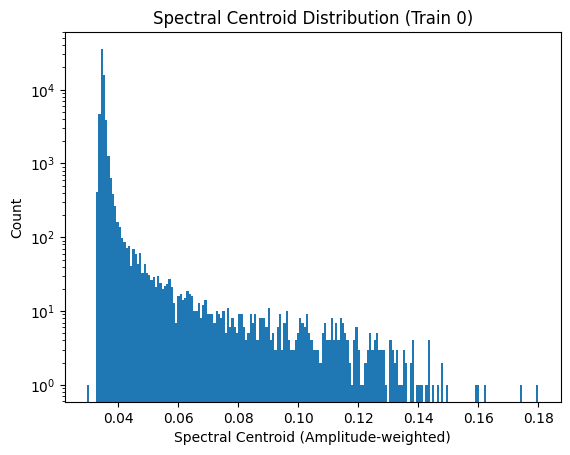

In [34]:
import matplotlib.pyplot as plt
import numpy as np

vals = df["SCA"].to_numpy(dtype=float)
vals = vals[np.isfinite(vals)]

plt.figure()
plt.hist(vals, bins=200)
plt.yscale("log")
plt.xlabel("Spectral Centroid (Amplitude-weighted)")
plt.ylabel("Count")
plt.title("Spectral Centroid Distribution (Train 0)")
plt.show()
